In [30]:
import skimage
import skimage.filters
from pathlib import Path
import io3d
from matplotlib import pyplot as plt
import scipy
import exsu
from skimage.morphology import label
from scipy.ndimage.morphology import binary_closing, binary_erosion, binary_opening, binary_dilation
from skimage.color import label2rgb
from skimage.measure import regionprops, regionprops_table
import skimage.io
import pandas as pd
from sklearn import datasets
import numpy as np
import seaborn as sns
import sklearn.model_selection
import exsu

0.03690036900369004

In [32]:
separate_cells = False
# 271px = 10um
# pxsz_mm = 0.010/271
debug = True
debug = False
pxsz_um = 10.0/271.0
pxsz_um
pth = io3d.joinp("medical/orig/cardio_blood_cells/TP1_a")


report = exsu.Report()
pth.exists()

True

# Segmentation processing step by step

In [4]:
def q1_intensity(mask, img):
    return np.quantile(img[mask], 0.25)
def q2_intensity(mask, img):
    return np.quantile(img[mask], 0.5)
def q3_intensity(mask, img):
    return np.quantile(img[mask], 0.75)

def quartiles(regionmask, intensity):
    return np.percentile(intensity[regionmask], q=(25, 50, 75))


C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


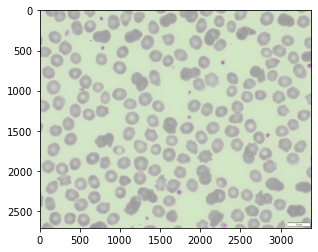

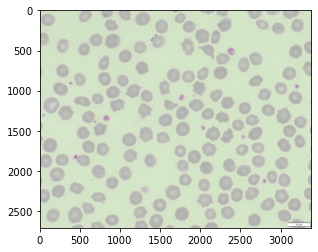

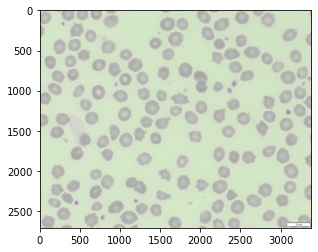

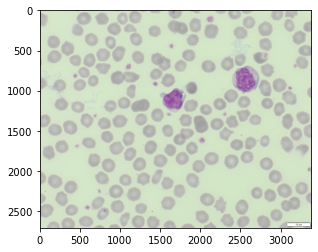

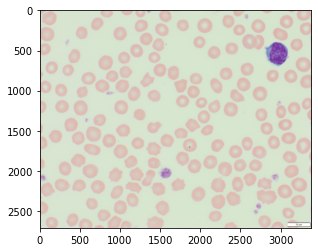

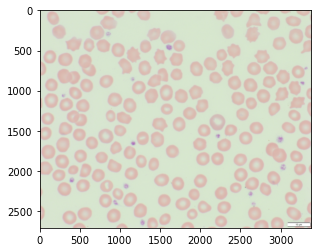

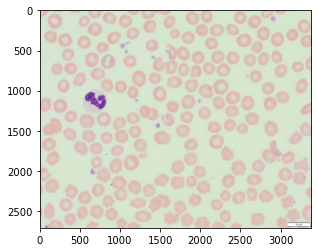

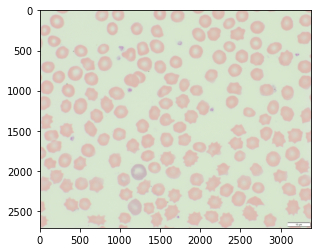

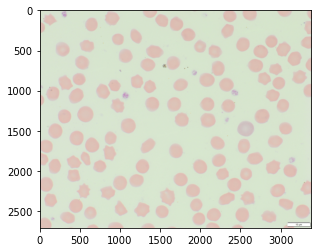

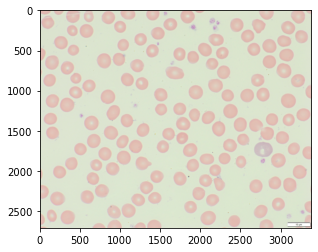

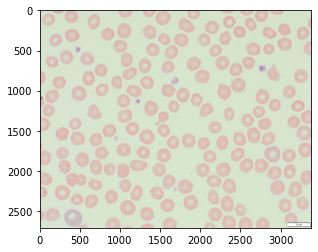

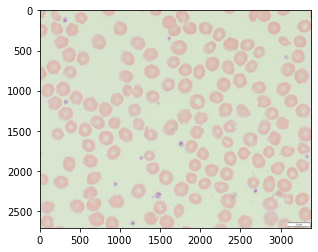

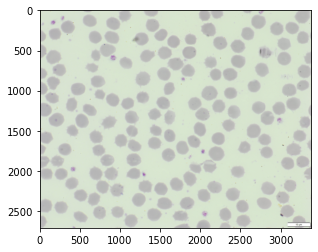

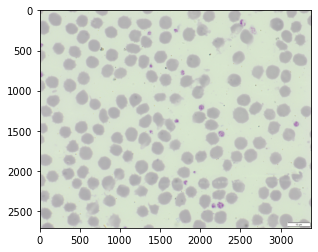

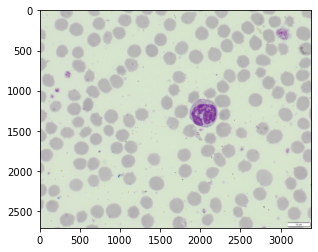

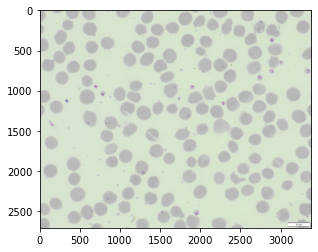

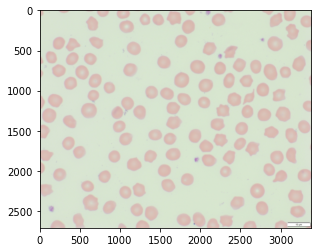

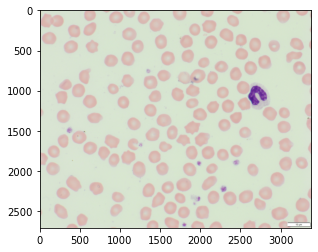

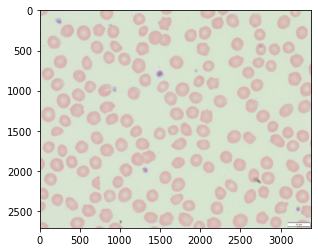

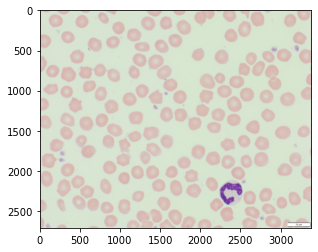

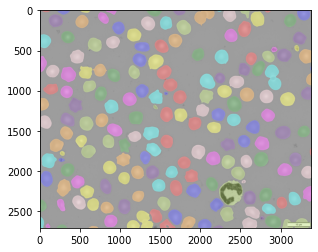

In [13]:
# for fn in pth.glob("*.jpg"):

fns = list(pth.glob("*jpg"))

dfsl = []

for fn in fns:

    im = skimage.io.imread(fn)
    plt.imshow(im)

    report = exsu.Report("report", show=True)

    def show_if_debug(*args, debug=True, show_colorbar=False, **kwargs):
        if debug:
            plt.figure()
            plt.imshow(*args, **kwargs)
            if show_colorbar:
                plt.colorbar()


    img = skimage.color.rgb2gray(im)
    show_if_debug(img, debug=debug, show_colorbar=True)


    threshold = skimage.filters.threshold_otsu(img[:])


    bim = img < threshold
    show_if_debug(bim, debug=debug)


    bim = scipy.ndimage.binary_fill_holes(bim)
    show_if_debug(bim, debug=debug)


    bim = skimage.morphology.remove_small_objects(bim, min_size=1000)
    show_if_debug(bim, debug=debug)

    if separate_cells:
        bimd = binary_erosion(bim,iterations=50)
        bimd[-100:,-500:] = 0  # remove size tag
        show_if_debug(bimd, debug=debug)

        distance = scipy.ndimage.distance_transform_edt(bim)
        show_if_debug(distance, debug=debug)

        imlabel = skimage.morphology.watershed(-distance, markers=label(bimd), mask=bim)
        show_if_debug(imlabel, debug=debug)
    else:
        imlabel = label(bim)


    # Segmented cells

    imrgb = label2rgb(imlabel, image=img, bg_label=0)
    show_if_debug(imrgb)


    # Cell shape description


    # dfi = pd.DataFrame(regionprops_table(imlabel, intensity_image=img))
    dfi = pd.DataFrame(regionprops_table(
        imlabel, intensity_image=np.uint8(255 * img),
        properties=(
            "label",
            "area",
            "perimeter",
            "max_intensity",
            "mean_intensity",
            "min_intensity",
            "solidity",
            "minor_axis_length",
            "major_axis_length",
            "eccentricity",

        ),
        # extra_properties=[q1_intensity]
    ))


    extra_properties=(quartiles,)
    extra_properties=[
        q1_intensity,
        q2_intensity,
        q2_intensity,
    ]
    for ep in extra_properties:
        values = []
        for i in range(np.max(imlabel)):
            values.append(ep(imlabel==i, 255*img))

        dfi[str(ep.__name__)] = values
        dfi["filename"] = fn.name

        dfsl.append(dfi)


    df = pd.concat(dfsl)

In [17]:
df.reset_index()
df.to_csv("blood_cells.csv")


In [51]:
df = pd.read_csv("blood_cells.csv", index_col=0).reset_index()
df[["perimeter", "minor_axis_length", "major_axis_length"]] *= pxsz_um
df[["area"]] *= pxsz_um**2

In [52]:
df.filename.str.split("_")

0        [TP1, a.jpg]
1        [TP1, a.jpg]
2        [TP1, a.jpg]
3        [TP1, a.jpg]
4        [TP1, a.jpg]
             ...     
10303    [TP5, d.jpg]
10304    [TP5, d.jpg]
10305    [TP5, d.jpg]
10306    [TP5, d.jpg]
10307    [TP5, d.jpg]
Name: filename, Length: 10308, dtype: object

In [53]:
df.filename.unique()

array(['TP1_a.jpg', 'TP1_b.jpg', 'TP1_c.jpg', 'TP1_d.jpg', 'TP2_a.jpg',
       'TP2_b.jpg', 'TP2_c.jpg', 'TP2_d.jpg', 'TP3_a.jpg', 'TP3_b.jpg',
       'TP3_c.jpg', 'TP3_d.jpg', 'TP4_a.jpg', 'TP4_b.jpg', 'TP4_c.jpg',
       'TP4_d.jpg', 'TP5_a.jpg', 'TP5_b.jpg', 'TP5_c.jpg', 'TP5_d.jpg'],
      dtype=object)

In [121]:
df["cl"] = df.filename.str.extract('(\d+)').astype(int)
df["noncompactness"] = df.perimeter**2 / df.area
df["q1q2"] = df.q1_intensity / df.q2_intensity
df["mima"] = df.minor_axis_length / df.major_axis_length
df["im_id"] = df.filename.str.extract('_([abcd])')
df.im_id = df.im_id.map(dict(a=1, b=2, c=3, d=4))
df["schistocyt"] = df.noncompactness > 20.
df.im_id
df["cls"] = (df.cl>1) * 2 +  (df.schistocyt * 1)
df

index  label       area  perimeter  max_intensity  mean_intensity  \
0          0      1  36.333928  26.954167            198      176.571054   
1          1      2  23.106984  18.565308            198      175.154449   
2          2      3  13.278686  15.433571            198      180.207855   
3          3      4  63.268474  43.710084            203      180.553556   
4          4      5   6.490925  12.506641            198      174.928886   
...      ...    ...        ...        ...            ...             ...   
10303    172    173  17.750303  17.204789            215      199.371280   
10304    173    174   3.297885   7.420496            208      191.274979   
10305    174    175   5.727046  11.367525            208      195.330005   
10306    175    176   4.042701  10.871224            208      194.927585   
10307    176    177   3.018750   9.571844            208      196.281912   

       min_intensity  solidity  minor_axis_length  major_axis_length  ...  \
0                159  0.937531           4.970609          10.104880  ...   
1                160  0.991818           4.826479           6.215501  ...   
2                166  0.939499           3.473244           5.178715  ...   
3                156  0.823745           6.886637          13.831007  ...   
4                164  0.981874           1.822132           4.952997  ...   
...              ...       ...                ...                ...  ...   
10303            193  0.987651           3.812166           6.146568  ...   
10304            169  0.949804           1.950088           2.246897  ...   
10305            191  0.983860           1.719096           4.561194  ...   
10306            190  0.972486           1.279805           4.503652  ...   
10307            191  0.975792           0.977120           4.220598  ...   

        filename  q2_intensity cl  noncompactness      q1q2      mima  im_id  \
0      TP1_a.jpg      221.6533  1       19.995833  0.994838  0.491902      1   
1      TP1_a.jpg      177.2145  1       14.916298  0.965318  0.776523      1   
2      TP1_a.jpg      174.2760  1       17.938154  0.973406  0.670677      1   
3      TP1_a.jpg      179.4270  1       30.197844  0.981281  0.497913      1   
4      TP1_a.jpg      181.0683  1       24.097657  0.956625  0.367885      1   
...          ...           ... ..             ...       ...       ...    ...   
10303  TP5_d.jpg      194.7982  5       16.676040  0.990794  0.620210      4   
10304  TP5_d.jpg      197.8116  5       16.696689  0.992680  0.867903      4   
10305  TP5_d.jpg      191.6959  5       22.563223  0.967572  0.376896      4   
10306  TP5_d.jpg      194.5078  5       29.233801  0.994859  0.284170      4   
10307  TP5_d.jpg      193.3636  5       30.350378  0.994122  0.231512      4   

       schistocit  schistocyt  cls  
0            True       False    0  
1           False       False    0  
2            True       False    0  
3            True        True    1  
4            True        True    1  
...           ...         ...  ...  
10303        True       False    2  
10304        True       False    2  
10305        True        True    3  
10306        True        True    3  
10307        True        True    3  

[10308 rows x 22 columns]

# Remove large cells

In [122]:

dfs = df[df.area < (0.9e4 * pxsz_um**2)]

#     y = 1
#
# elif props.area > 2.9e4:
#     y = 1
# else:
#
#     # normal size
#     if (props.perimeter**2) / props.area < 15.5:
#         y = 2
#     else:
#         y = 3

In [123]:
dfs = dfs[(dfs['cl'] == 1) | (dfs['cl']==5)]
dfs.cl.unique()

array([1, 5])

In [124]:
def rem(keys, key):
    if key in keys:
        keys.remove(key)
dfs

index  label      area  perimeter  max_intensity  mean_intensity  \
4          4      5  6.490925  12.506641            198      174.928886   
7          7      8  6.429651  12.276286            198      177.876112   
9          9     10  1.903569   9.436905            198      184.133763   
10        10     11  4.818834  11.801601            198      182.159367   
17        17     18  2.388312   6.280294            198      161.450969   
...      ...    ...       ...        ...            ...             ...   
10298    167    168  8.010512  13.153802            208      193.843277   
10304    173    174  3.297885   7.420496            208      191.274979   
10305    174    175  5.727046  11.367525            208      195.330005   
10306    175    176  4.042701  10.871224            208      194.927585   
10307    176    177  3.018750   9.571844            208      196.281912   

       min_intensity  solidity  minor_axis_length  major_axis_length  ...  \
4                164  0.981874           1.822132           4.952997  ...   
7                168  0.984160           1.798226           4.970010  ...   
9                171  0.916721           0.665781           4.257151  ...   
10               172  0.943230           1.628533           4.460841  ...   
17               102  0.949134           1.608256           1.910523  ...   
...              ...       ...                ...                ...  ...   
10298            188  0.980337           1.981589           5.392666  ...   
10304            169  0.949804           1.950088           2.246897  ...   
10305            191  0.983860           1.719096           4.561194  ...   
10306            190  0.972486           1.279805           4.503652  ...   
10307            191  0.975792           0.977120           4.220598  ...   

        filename  q2_intensity cl  noncompactness      q1q2      mima  im_id  \
4      TP1_a.jpg      181.0683  1       24.097657  0.956625  0.367885      1   
7      TP1_a.jpg      178.9241  1       23.439404  0.972055  0.361815      1   
9      TP1_a.jpg      181.2145  1       46.783267  0.970429  0.156391      1   
10     TP1_a.jpg      183.8578  1       28.902795  0.972370  0.365073      1   
17     TP1_a.jpg      177.0683  1       16.514632  0.977410  0.841789      1   
...          ...           ... ..             ...       ...       ...    ...   
10298  TP5_d.jpg      195.3790  5       21.599433  0.989685  0.367460      4   
10304  TP5_d.jpg      197.8116  5       16.696689  0.992680  0.867903      4   
10305  TP5_d.jpg      191.6959  5       22.563223  0.967572  0.376896      4   
10306  TP5_d.jpg      194.5078  5       29.233801  0.994859  0.284170      4   
10307  TP5_d.jpg      193.3636  5       30.350378  0.994122  0.231512      4   

       schistocit  schistocyt  cls  
4            True        True    1  
7            True        True    1  
9            True        True    1  
10           True        True    1  
17           True       False    0  
...           ...         ...  ...  
10298        True        True    3  
10304        True       False    2  
10305        True        True    3  
10306        True        True    3  
10307        True        True    3  

[558 rows x 22 columns]

In [125]:
keys = list(df.keys())
keys.remove("index")
keys.remove("label")
keys.remove("cl")
rem(keys, "class")
rem(keys, "min_intensity")
rem(keys, "max_intensity")
rem(keys, "mean_intensity")
rem(keys, "q1_intensity")
rem(keys, "q2_intensity")
rem(keys, "filename")
# if "class" in keys:
#     keys.remove("class")
keys

['area',
 'perimeter',
 'solidity',
 'minor_axis_length',
 'major_axis_length',
 'eccentricity',
 'noncompactness',
 'q1q2',
 'mima',
 'im_id',
 'schistocit',
 'schistocyt',
 'cls']

In [ ]:
dfs

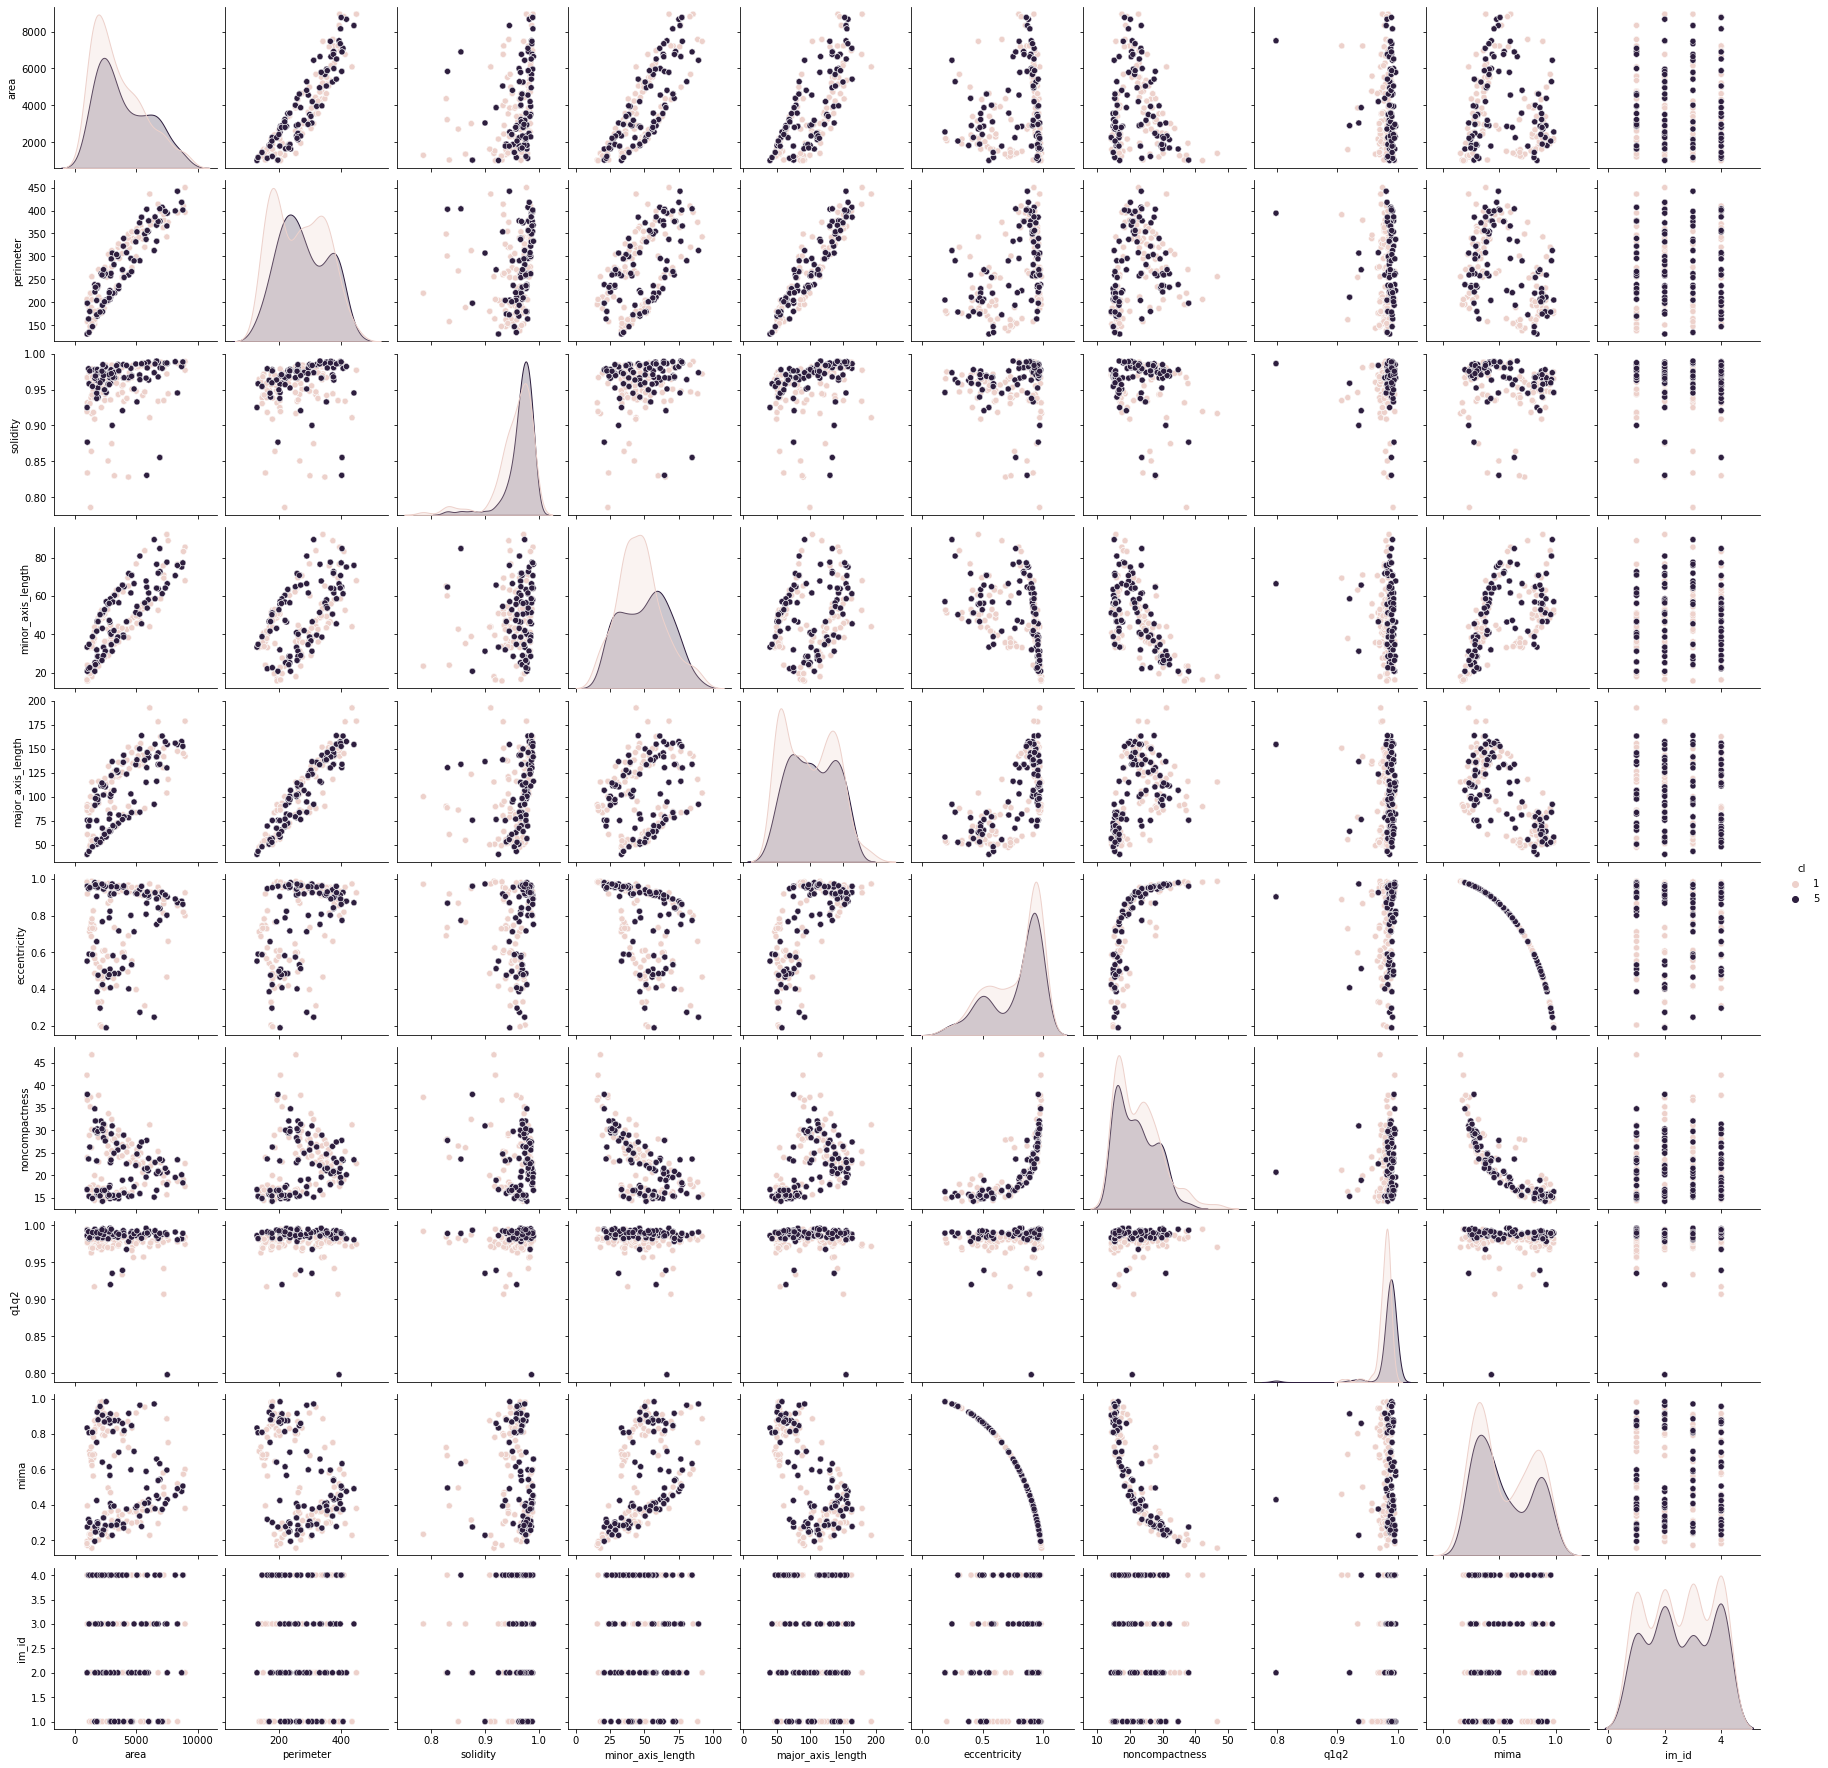

In [152]:
# sns.pairplot(data=dfs, hue="cl", vars=keys)
# plt.savefig("pairplot.pdf")

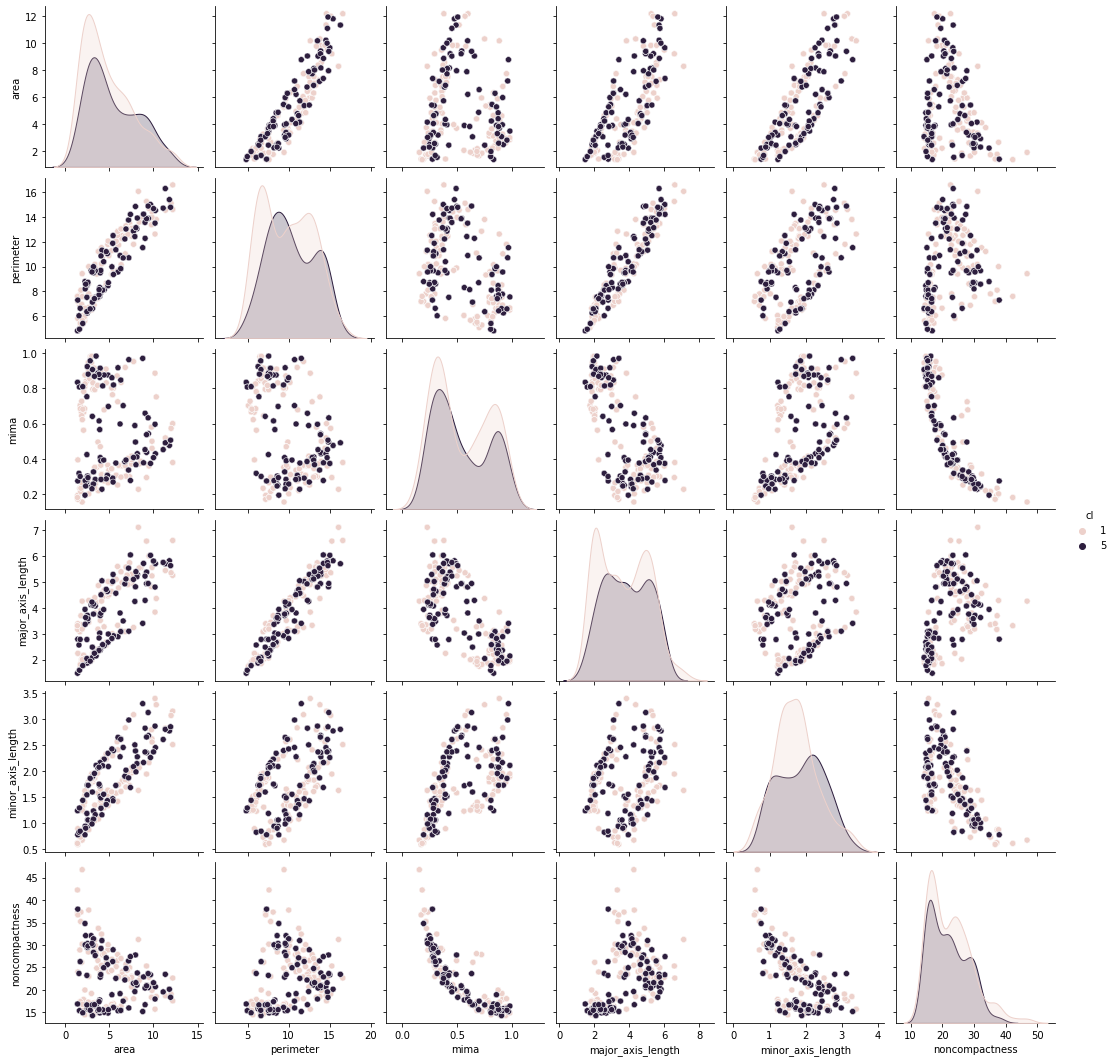

In [142]:
vars=["area", "perimeter", "mima", "major_axis_length", "minor_axis_length", "noncompactness"]


sns.pairplot(data=dfs, hue="cl",
             # size="cl",
             # style="cls",
             vars=vars)




# Schistocyt separation

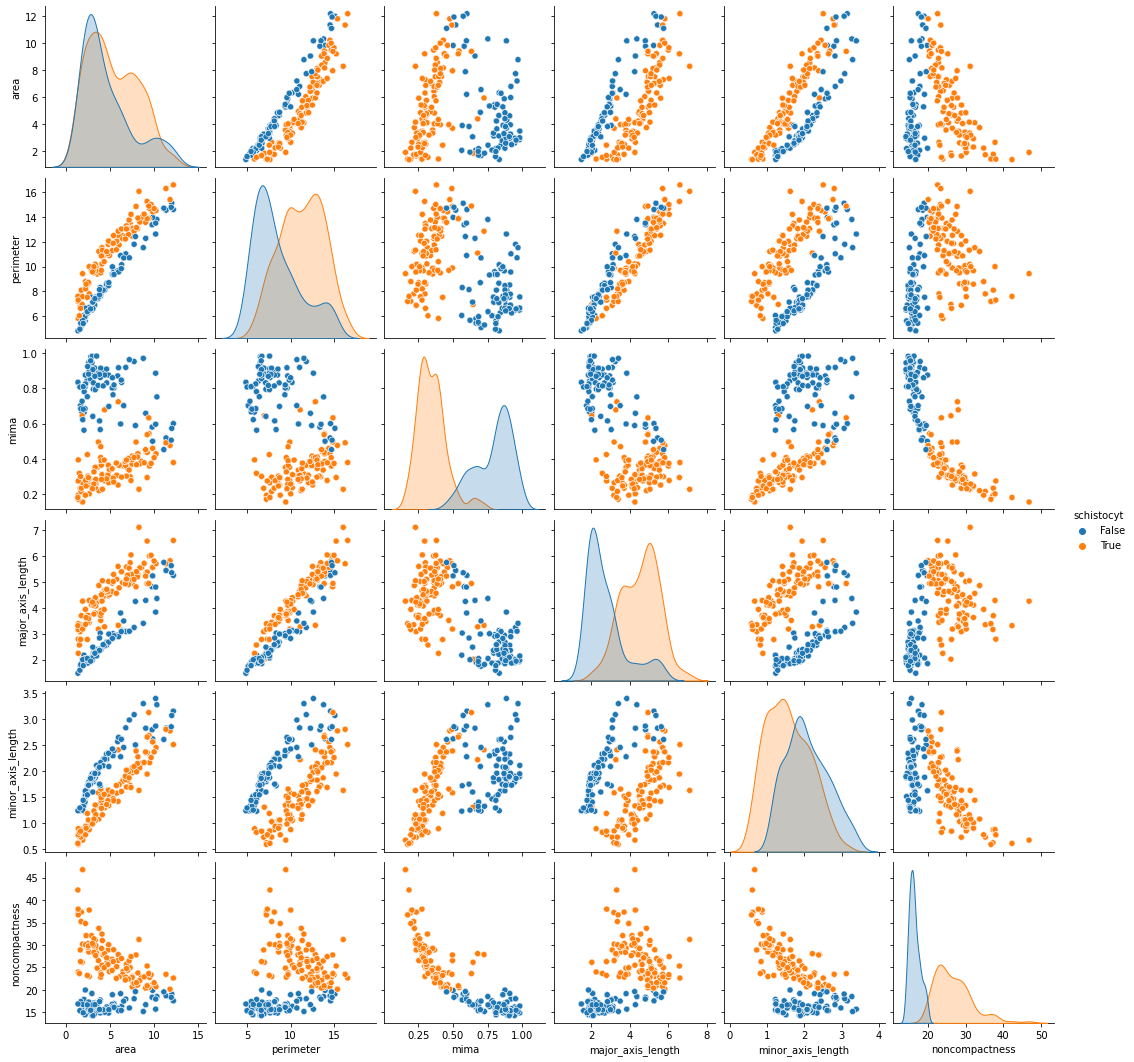

In [127]:
sns.pairplot(data=dfs, hue="schistocyt",
             # size="cl",
             # style="cls",
             vars=vars)


# Schistocyt separation

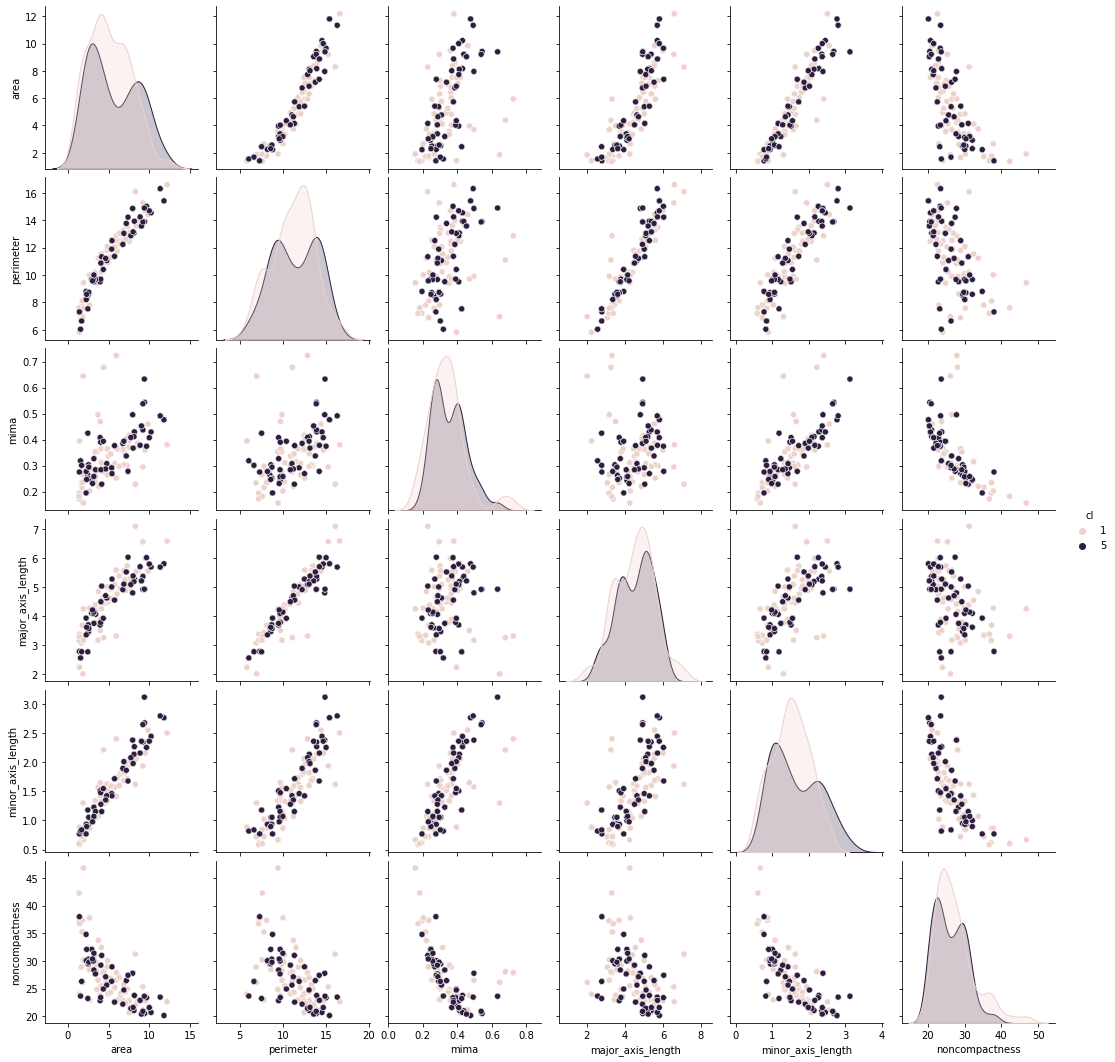

In [128]:
sns.pairplot(data=dfs[dfs.schistocyt==True], hue="cl",
             # size="cl",
             # style="cls",
             vars=["area", "perimeter", "mima", "major_axis_length", "minor_axis_length", "noncompactness"])

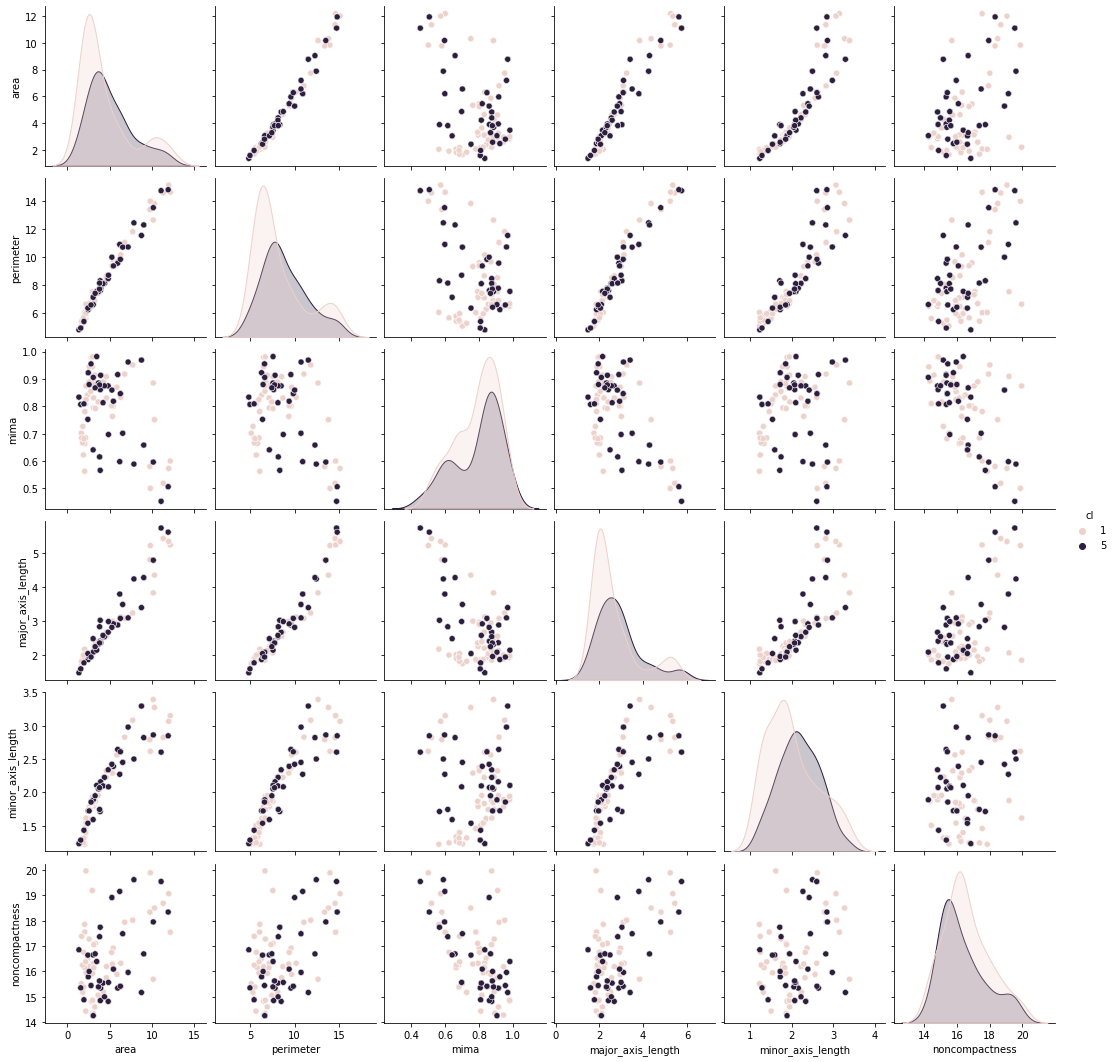

In [129]:
sns.pairplot(data=dfs[dfs.schistocyt==False], hue="cl",
             # size="cl",
             # style="cls",
             vars=["area", "perimeter", "mima", "major_axis_length", "minor_axis_length", "noncompactness"])

In [65]:
dfs.describe()

index       label        area   perimeter  max_intensity  \
count  558.000000  558.000000  558.000000  558.000000     558.000000   
mean    82.731183   83.731183    5.063468   10.048412     204.139785   
std     62.235230   62.235230    2.850259    2.984568       3.779634   
min      0.000000    1.000000    1.368445    4.821736     198.000000   
25%     18.000000   19.000000    2.652469    7.527039     201.000000   
50%     77.000000   78.000000    4.229245    9.782345     203.000000   
75%    139.000000  140.000000    7.095492   12.538072     208.000000   
max    189.000000  190.000000   12.183930   16.606516     209.000000   

       mean_intensity  min_intensity    solidity  minor_axis_length  \
count      558.000000     558.000000  558.000000         558.000000   
mean       184.306755     162.478495    0.958671           1.794604   
std          9.032473      24.220088    0.033987           0.629748   
min        159.312798     100.000000    0.785541           0.583098   
25%        178.125528     145.000000    0.948525           1.318336   
50%        185.625291     172.000000    0.968373           1.764580   
75%        191.414815     183.000000    0.980712           2.235099   
max        203.056256     196.000000    0.990018           3.395328   

       major_axis_length  eccentricity  q1_intensity  q2_intensity  \
count         558.000000    558.000000    558.000000    558.000000   
mean            3.737889      0.773366    184.143203    187.758587   
std             1.348497      0.215883     10.435611      8.914953   
min             1.477624      0.187491    138.277350    162.497100   
25%             2.483755      0.587293    178.068300    181.924100   
50%             3.698636      0.889636    182.924100    186.845200   
75%             4.947836      0.951312    190.507800    193.227000   
max             7.105245      0.987695    223.436800    224.436800   

               cl  noncompactness        q1q2        mima       im_id  
count  558.000000      558.000000  558.000000  558.000000  558.000000  
mean     2.763441       22.245640    0.980445    0.541044    2.559140  
std      1.987743        6.389758    0.018713    0.250535    1.127069  
min      1.000000       14.259615    0.798366    0.156391    1.000000  
25%      1.000000       16.378664    0.978617    0.308229    2.000000  
50%      1.000000       21.459753    0.983993    0.456654    3.000000  
75%      5.000000       26.523386    0.988898    0.809375    4.000000  
max      5.000000       46.783267    0.996189    0.982266    4.000000

In [22]:
dfs.im_id


4        1
7        1
9        1
10       1
17       1
        ..
10298    4
10304    4
10305    4
10306    4
10307    4
Name: im_id, Length: 558, dtype: int64

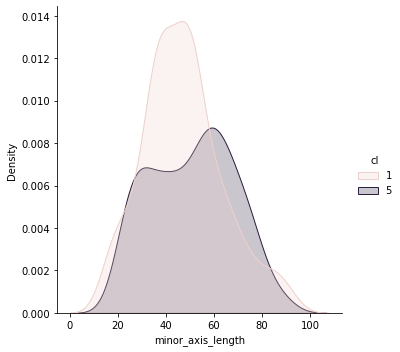

In [23]:

sns.displot(data=dfs, x="minor_axis_length", hue="cl", kind="kde", fill=True)

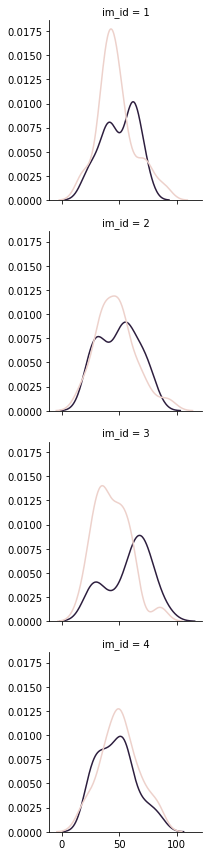

In [24]:
# g = sns.PairGrid(dfs, x_vars="im_id", hue="cl")
g = sns.FacetGrid(dfs, row="im_id")
g.map_dataframe(sns.kdeplot, x="minor_axis_length", hue="cl")

In [145]:
pd.pivot_table(dfs, columns="im_id", index=["cl", "schistocyt"], values="minor_axis_length", aggfunc="count")

im_id           1   2   3   4
cl schistocyt                
1  False       36  24  36  45
   True        39  51  42  39
5  False       21  24  27  33
   True        33  45  24  39

In [26]:
dfs.minor_axis_length

4        49.379776
7        48.731915
9        18.042669
10       44.133237
17       43.583750
           ...    
10298    53.701069
10304    52.847397
10305    46.587502
10306    34.682703
10307    26.479945
Name: minor_axis_length, Length: 558, dtype: float64

KstestResult(statistic=0.22045028142589118, pvalue=2.3717501277387143e-06)
312 246


Power_divergenceResult(statistic=128.11655011655012, pvalue=2.8921106345749273e-23)

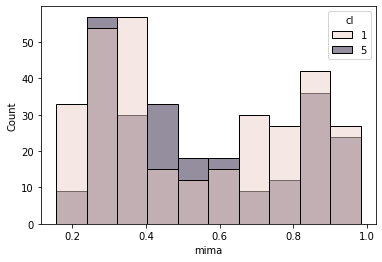

In [144]:
import scipy.stats
bins = 10
prop = "minor_axis_length"
prop = "major_axis_length"
prop = "mima"
a = np.array(dfs[dfs.cl==1]["minor_axis_length"][dfs.im_id>0])
b = np.array(dfs[dfs.cl==5]["minor_axis_length"][dfs.im_id>0])
     # np.random.random(a.size)
sns.histplot(dfs, x=prop, hue="cl", bins=bins)
print(scipy.stats.kstest(list(a),list(b), N=bins))

print(len(a), len(b))
ya, bn = np.histogram(a, bins=bins)
yb, bn = np.histogram(b, bins=bn)
scipy.stats.chisquare(ya,yb)

## Checking hypothesis testing

KstestResult(statistic=0.041666666666666664, pvalue=0.9499065344511678)


C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\scipy\stats\stats.py:5982: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


Power_divergenceResult(statistic=inf, pvalue=0.0)

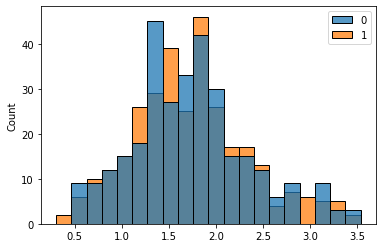

In [146]:
bins = 20
aa = a + 0.1  * np.random.standard_normal(a.shape)
sns.histplot([a, aa], bins=bins)
print(scipy.stats.kstest(list(a),list(aa), N=bins))


ya, bn = np.histogram(a*10, bins=bins)
yb, bn = np.histogram(aa*19, bins=bn)
scipy.stats.chisquare(ya,yb)

In [174]:
scipy.__version__


'1.2.0'

In [81]:
np.random.standard_normal([10])


array([ 1.26864462,  0.09314555, -0.55098952,  0.43100412, -1.42097958,
        1.86059008, -0.29916031, -0.16357403, -0.32789068, -0.55297935])